In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
# load data
data_1 = pd.read_csv("datatraining.csv")
data_2 = pd.read_csv("datatest.csv")
data_3 = pd.read_csv("datatest2.csv")

uci_data = pd.concat([data_1, data_2, data_3])
uci_data.date = pd.to_datetime(uci_data.date)
uci_data.set_index('date', inplace=True)

# Resampling

In [3]:
uci_sampling = uci_data.resample('5min').mean()

# Fill Missing Value

In [4]:
uci_sampling = uci_sampling.interpolate(method ='linear', limit_direction ='forward')

In [5]:
# uci_sampling = uci_sampling.drop (columns = ['Occupancy'])
# uci_sampling['Occupancy'] = uci_sampling['Occupancy'].apply(np.ceil)

# Normalize 

In [6]:
def normalize(dataset):
    dataNorm=((dataset-dataset.min())/(dataset.max() - dataset.min()))
    dataNorm['Occupancy'] = dataset['Occupancy']
    return dataNorm

In [9]:
datanorm = normalize(uci_sampling)
datanorm = datanorm.drop(columns = ['Occupancy'])

# Prepare Data

In [10]:
datanorm.head()

,Temperature,Humidity,Light,CO2,HumidityRatio
date,,,,,
2015-02-02 14:15:00,0.877034,0.417928,0.510615,0.210149,0.552324
2015-02-02 14:20:00,0.883176,0.414520,0.465961,0.224784,0.551078
2015-02-02 14:25:00,0.883585,0.421105,0.441076,0.241023,0.558496
2015-02-02 14:30:00,0.875340,0.436627,0.413205,0.264918,0.572176
2015-02-02 14:35:00,0.863731,0.450744,0.404888,0.299943,0.582832


In [11]:
input_feature = datanorm.iloc[:,[0,1,2,3,4]].values
input_data = input_feature

In [12]:
lookback= 12
train_size = int(.8 * len(datanorm))
test_size=int(.2 * len(datanorm))
X=[]
y=[]
for i in range(len(datanorm)-lookback-1):
    t=[]
    for j in range(0,lookback):
        
        t.append(input_data[[(i+j)], :])
    X.append(t)
    y.append(input_data[i+ lookback,:5])

In [13]:
train_size

3639

In [14]:
X, y= np.array(X), np.array(y)
X_train, y_train = X[:train_size+lookback], y[:train_size+lookback] 
X_test, y_test = X[:test_size+lookback], y[:test_size+lookback] 
X = X.reshape(X.shape[0],lookback, 5)
X_train = X_train.reshape(X_train.shape[0],lookback, 5)
X_test = X_test.reshape(X_test.shape[0],lookback, 5)
print(X.shape)
print(X_test.shape)
print(y_test.shape)

(4536, 12, 5)
(921, 12, 5)
(921, 5)


# LSTM

In [15]:
from keras import Sequential
from keras.layers import Dense, LSTM

Using TensorFlow backend.


In [16]:
model = Sequential()
model.add(LSTM(units=84, activation='relu', return_sequences = True, input_shape=(X.shape[1], 5)))
model.add(LSTM(units=84, activation='relu'))
model.add(Dense(units=5, activation='relu'))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 12, 84)            30240     
_________________________________________________________________
lstm_2 (LSTM)                (None, 84)                56784     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 425       
Total params: 87,449
Trainable params: 87,449
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae', 'mape', 'acc'])

In [18]:
model.fit(X_train, y_train, epochs=100, batch_size=100)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
3651/3651 [==============================] - 4s 1ms/step - loss: 0.0988 - mean_squared_error: 0.0988 - mean_absolute_error: 0.2173 - mean_absolute_percentage_error: 25999.1425 - acc: 0.1780
Epoch 2/100
3651/3651 [==============================] - 1s 364us/step - loss: 0.0806 - mean_squared_error: 0.0806 - mean_absolute_error: 0.1695 - mean_absolute_percentage_error: 17223.0448 - acc: 0.4103
Epoch 3/100
3651/3651 [==============================] - 1s 375us/step - loss: 0.0801 - mean_squared_error: 0.0801 - mean_absolute_error: 0.1648 - mean_absolute_percentage_error: 10550.2483 - acc: 0.4117
Epoch 4/100
3651/3651 [==============================] - 1s 363us/step - loss: 0.0785 - mean_squared_error: 0.0785 - mean_absolute_error: 0.1612 - mean_absolute_percentage_error: 66715.9967 - acc: 0.4103
Epoch 5/100
3651/3651 [==============================] - 1s 380us/step - loss: 0.0624 - mean_squared_error: 0.0624 - mean_absolute_error: 

3651/3651 [==============================] - 1s 360us/step - loss: 0.0575 - mean_squared_error: 0.0575 - mean_absolute_error: 0.1025 - mean_absolute_percentage_error: 221327.4991 - acc: 0.4278
Epoch 79/100
3651/3651 [==============================] - 1s 358us/step - loss: 0.0575 - mean_squared_error: 0.0575 - mean_absolute_error: 0.1024 - mean_absolute_percentage_error: 225710.8089 - acc: 0.4281
Epoch 80/100
3651/3651 [==============================] - 1s 354us/step - loss: 0.0575 - mean_squared_error: 0.0575 - mean_absolute_error: 0.1030 - mean_absolute_percentage_error: 273120.6034 - acc: 0.4254
Epoch 81/100
3651/3651 [==============================] - 1s 367us/step - loss: 0.0575 - mean_squared_error: 0.0575 - mean_absolute_error: 0.1026 - mean_absolute_percentage_error: 252083.8259 - acc: 0.4292
Epoch 82/100
3651/3651 [==============================] - 1s 371us/step - loss: 0.0575 - mean_squared_error: 0.0575 - mean_absolute_error: 0.1036 - mean_absolute_percentage_error: 215974.77

In [19]:
predicted_value= model.predict(X_test)

In [20]:
datanorm.head()

,Temperature,Humidity,Light,CO2,HumidityRatio
date,,,,,
2015-02-02 14:15:00,0.877034,0.417928,0.510615,0.210149,0.552324
2015-02-02 14:20:00,0.883176,0.414520,0.465961,0.224784,0.551078
2015-02-02 14:25:00,0.883585,0.421105,0.441076,0.241023,0.558496
2015-02-02 14:30:00,0.875340,0.436627,0.413205,0.264918,0.572176
2015-02-02 14:35:00,0.863731,0.450744,0.404888,0.299943,0.582832


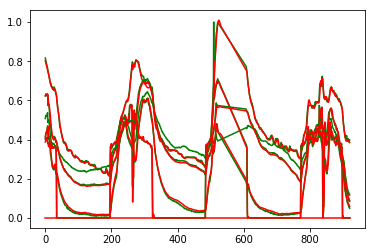

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
for i in range(5):
    plt.plot(y_test[:, i], color='green')
    plt.plot(predicted_value[:, i], color= 'red')
#     plt.show()
# plt.title("Opening price of stocks sold")
# plt.xlabel("Time (latest-> oldest)")
# plt.ylabel("Stock Opening Price")
# plt.show()

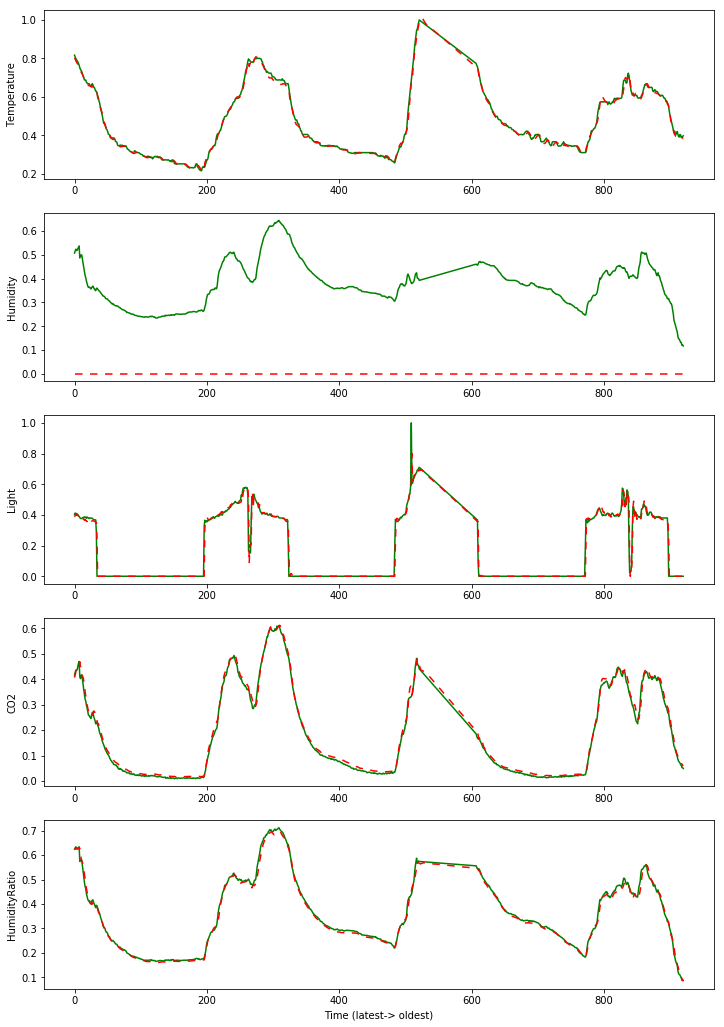

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
groups = [0,1,2,3,4]
labels = ['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio']
i = 1
plt.figure(figsize = (12,18))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(y_test[:, group], color='green')
    plt.plot(predicted_value[:, group], color= 'red', dashes = (5,5,5,5))
    plt.ylabel(labels[group])
    i += 1
# 'Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio'
# plt.title("IAQ Attributes",)
plt.xlabel("Time (latest-> oldest)")

plt.savefig('lstm acc.png')
plt.show()

# MAE

In [23]:
from sklearn.metrics import mean_absolute_error

acclist = []
for i in range (y_test.shape[1]):
    acc = mean_absolute_error(y_test[:, i],predicted_value[:, i])
    acclist.append(acc)
    
acclist_np = np.array(acclist)
np.mean(acclist_np)

0.08288615061460698

# Denormalization

In [24]:
def denormalize(dataNorm, dataset):
    data = dataNorm * (dataset.max() - dataset.min()) + dataset.min()
    return data

In [25]:
denorm = []
for i in range (y_test.shape[1]):
    ytest = denormalize(predicted_value[:,i], uci_sampling.iloc[:, i])
    denorm.append(ytest)
denorm = np.array(denorm)

denorm = np.transpose(denorm)
denorm

array([[2.3312477e+01, 1.6808889e+01, 4.4168723e+02, 1.0695415e+03,
        5.0320644e-03],
       [2.3271877e+01, 1.6808889e+01, 4.4977866e+02, 1.0876281e+03,
        5.0400756e-03],
       [2.3235239e+01, 1.6808889e+01, 4.6187180e+02, 1.1054548e+03,
        5.0483993e-03],
       ...,
       [2.1117720e+01, 1.6808889e+01, 0.0000000e+00, 5.2398541e+02,
        3.0446649e-03],
       [2.1100977e+01, 1.6808889e+01, 0.0000000e+00, 5.1681201e+02,
        3.0215175e-03],
       [2.1092731e+01, 1.6808889e+01, 0.0000000e+00, 5.1170532e+02,
        3.0049437e-03]], dtype=float32)

In [26]:
denormy_test = []
for i in range (y_test.shape[1]):
    ytest = denormalize(y_test[:,i], uci_sampling.iloc[:, i])
    denormy_test.append(ytest)
denormy_test = np.array(denormy_test)

denormy_test = np.transpose(denormy_test)
denormy_test

array([[2.33860000e+01, 2.83018333e+01, 4.59000000e+02, 1.08568667e+03,
        5.03822172e-03],
       [2.33413889e+01, 2.84963889e+01, 4.69486111e+02, 1.10365278e+03,
        5.05939353e-03],
       [2.32900000e+01, 2.86703333e+01, 4.64850000e+02, 1.11562333e+03,
        5.07462259e-03],
       ...,
       [2.11150000e+01, 1.95220000e+01, 0.00000000e+00, 5.02500000e+02,
        3.01677148e-03],
       [2.11375000e+01, 1.95562500e+01, 0.00000000e+00, 5.01541667e+02,
        3.02625657e-03],
       [2.11633333e+01, 1.94553333e+01, 0.00000000e+00, 4.95833333e+02,
        3.01536012e-03]])

In [27]:
from sklearn.metrics import mean_absolute_error

acclist = []
for i in range (y_test.shape[1]):
    acc = mean_absolute_error(denormy_test[i, :],denorm[i, :])
    acclist.append(acc)
    
acclist_np = np.array(acclist)
np.mean(acclist_np)

6.833987668466382

In [28]:
new_data = pd.DataFrame(columns=['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio'], data = denorm)

In [29]:
new_data.to_excel('prediction_new_rev.xlsx', engine='xlsxwriter', index=False)

In [30]:
new_data.to_excel('prediction_new.xlsx', engine='xlsxwriter', index=False)

In [31]:
import numpy as np
from keras import models
from keras import layers
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_classification

np.random.seed(0)

In [33]:
datanorm_ann = normalize(uci_sampling)

In [34]:
X_ann = datanorm_ann.iloc[:,0:5]
y_ann = datanorm_ann.iloc[:,5].apply(np.ceil)
y_ann = datanorm_ann.astype(int)

In [40]:
features=X_ann.values
target = y_ann.values

In [43]:
target

array([[0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1]])

In [41]:
def create_network():
    
    network = models.Sequential()

    network.add(layers.Dense(units=30, activation='relu', input_shape=(features.shape[1],)))
    network.add(layers.Dense(units=1, activation='sigmoid'))

    network.compile(loss='binary_crossentropy', # Cross-entropy
                    optimizer='rmsprop', # Root Mean Square Propagation
                    metrics=['accuracy']) # Accuracy performance metric
    
    return network

In [42]:
model = create_network()                                                                                                                                                 
model.fit(features, target, epochs=100, batch_size=100, verbose=0, validation_split=0.2)

ValueError: Error when checking target: expected dense_5 to have shape (1,) but got array with shape (6,)